In [53]:
import hdf5storage
import rat.helpers as helpers
import rat.get_data as get_data
import numpy as np
from bat.helpers_bat import *
from bat.get_data import *


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading in the bat data (LFP and positional data)
We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a different file, but luckily the accessors for this were provided by the Yartsev lab (thanks Kevin Qi!).

In [54]:
# Loading bat LFP data
lfp_mat = hdf5storage.loadmat('./bat/data/ephys/32622_231007_lfp.mat')

# Check the structure of lfp_mat
print("Structure of lfp_mat:", type(lfp_mat['lfp']), lfp_mat['lfp'].shape)


Structure of lfp_mat: <class 'numpy.ndarray'> (1, 2)


In [55]:
data_path = './bat/data' # Replace this
bat_id = '32622'
date =  '231007'

In [56]:
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

Loading Flight Room | 32622 | 231007 from cache...


In [57]:
pos = session.cortex_data.bat_pos
pos.shape # (num_timepoints, XYZ)

(841160, 3)

Since the position data has a lot of NaNs throughout it, we can interpolate across these spans of NaN values to create a cleaner dataset. More on how this affects the data in ```example.ipynb```.

In [58]:
cleaned_pos = np.copy(pos)
# still position on walls are nans (dont interpolate large gaps of nans)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])
cleaned_pos.shape

(841160, 3)

## Time synchronization
Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [59]:
lfp_timestamps = lfp_mat['global_sample_timestamps_usec'] #global timestamps in microseconds

np.diff(lfp_timestamps.flatten()) #we will see a 400 microsecond difference between each timestamp,
#which means that the sampling rate is 2500 Hz

array([400.00444436, 400.0044446 , 400.00444436, ..., 399.99999905,
       400.        , 400.00000191])

In [60]:
lfp_timestamps.shape

(17222917, 1)

Above, we filtered out the negative timestamps from the position recording relative to the global timestamp start. We simply had to filter out the corresponding samples in position to synchronize. Now we're ready to make timebins from the LFP timestamp data and bin the positional data accordingly.

In [61]:
from scipy.signal import decimate
lfp_timestamps_dec = decimate(lfp_timestamps.flatten(), 100) #decimate from 2500 Hz to 25 Hz (100x decimation)
lfp_timestamps_dec.shape
lfp_timestamps_dec[0:10]

array([-60891106.62646672, -60852188.97429994, -60812040.07526092,
       -60773049.25066301, -60732691.27181993, -60693659.02537236,
       -60653551.67287268, -60614244.59181927, -60574604.15089313,
       -60535043.82082997])

Now that we downsampled the LFP timestamps, we will lop off negative timestamps to ensure that we have proper "edges" between bins (more on this later).

In [62]:
lfp_indices = lfp_timestamps_dec > 0 # lop off negative timestamps on LFP timestamps; we will use this to refit the LFP data later.
lfp_timestamps_dec = lfp_timestamps_dec[lfp_indices] 
lfp_timestamps_edges = np.insert(lfp_timestamps_dec, 0, 0) # insert 0 at the beginning

lfp_timestamps_edges.shape
lfp_timestamps_edges[0:10]

array([     0.        ,   4514.44262606,  44057.00577409,  83599.56892214,
       123142.1320702 , 162684.69521825, 202227.25836628, 241769.82151429,
       281312.3846624 , 320854.94781046])

We now have our decimated LFP timebins. Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average out points between edges of the LFP timebins to get synchronized data streams.

In [63]:
pos_timestamps = session.cortex_data.cortex_global_sample_timestamps_sec * 1e6 #converting to microseconds (usec)
valid_indices = pos_timestamps > 0 #we can use this to get rid of negative timestamps on anything position related

pos_timestamps = pos_timestamps[valid_indices] # lop off negative timestamps 
np.diff(pos_timestamps) #we will see an average of a 8333 microsecond difference between each timestamp, meaning that the sampling rate is around 120 Hz

array([8333.33333331, 8333.33333334, 8333.33333334, ..., 8333.33772278,
       8333.33771515, 8333.33771515])

In [64]:
cleaned_pos = cleaned_pos[valid_indices] # lop off the corresponding positions
cleaned_pos.shape

(824435, 3)

In [65]:
# Bin positional data using the provided label_timebins function
binned_pos_x = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 0], pos_timestamps, is_discrete=False)
binned_pos_y = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 1], pos_timestamps, is_discrete=False)
binned_pos_z = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 2], pos_timestamps, is_discrete=False)

In [66]:
# Construct the array according to its columns
binned_pos = np.column_stack((binned_pos_x, binned_pos_y, binned_pos_z))

# Verify the results
print("Binned position shape:", binned_pos.shape)
print("LFP timestamp edges shape:", lfp_timestamps_edges.shape)

print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

Binned position shape: (170690, 3)
LFP timestamp edges shape: (170691,)
First few elements of binned_pos:
 [[        nan         nan         nan]
 [-1.35497956 -1.70192085  0.01016301]
 [-1.35496366 -1.70190326  0.01020436]
 ...
 [-1.24507387 -1.627617    0.04300965]
 [-1.24505479 -1.62760721  0.0430833 ]
 [        nan         nan         nan]]
First few LFP bins: [     0.           4514.44262606  44057.00577409  83599.56892214
 123142.1320702 ]


Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

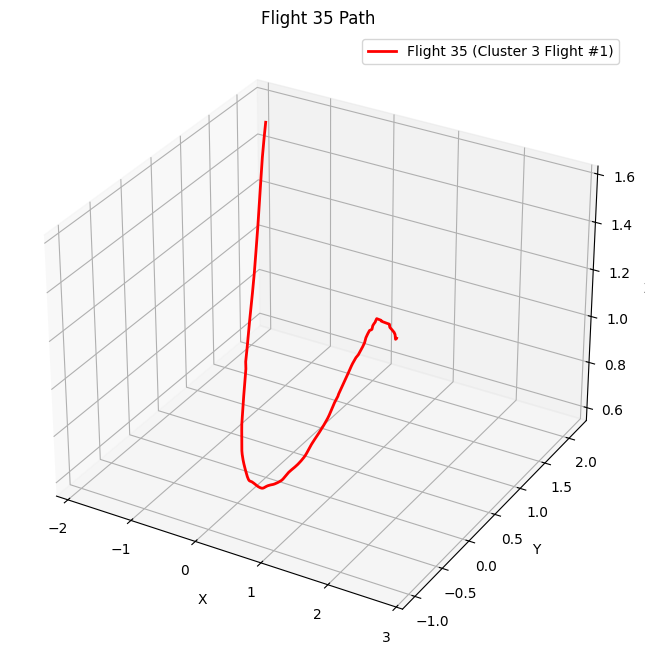

In [67]:
from bat.get_data import get_cluster_labels, get_flight_boolean_array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.colors as mcolors

clutser_2_labels = get_cluster_labels(session, 2)

# Get boolean array for the 35th flight overall (which might be in cluster 3)
flight_35_bool, flight_35_cluster = get_flight_boolean_array(session, 35)

# Create a new figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the boolean array for indexing or plotting
ax.plot(pos[flight_35_bool, 0], pos[flight_35_bool, 1], pos[flight_35_bool, 2],
        color='red', linewidth=2, label=f'Flight 35 (Cluster 3 Flight #1)')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Flight 35 Path')

# Add legend
ax.legend()

# Show the plot
plt.show()

We are creating labels (timebin_labels) to associate which timebins are related to which flight so we can access them accordingly.

In [68]:
labels = flight_35_bool[valid_indices] # we can also do this by cluster : labels = cluster_2_labels[valid_indices]
labels.shape

(824435,)

In [69]:
timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
timebin_labels.shape

(170690,)

In [70]:
print(len(binned_pos[0]), len(binned_pos[1]), len(timebin_labels))

3 3 170690


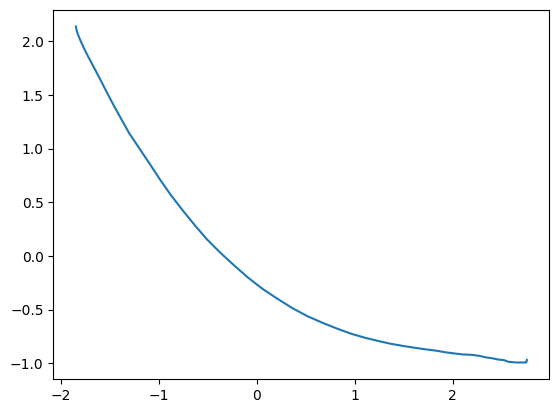

In [71]:
plt.plot(binned_pos[:, 0][:len(timebin_labels)][timebin_labels > 0], 
         binned_pos[:, 1][:len(timebin_labels)][timebin_labels > 0])

Using timebin_labels, we can filter out the binned position data for each flight. This will allow us to organize flight data later.

### Organizing behavioral data
To better organize the binned flight data, we need to construct a flightID array which will contain all the binned positions for each flight, accounting for which feeder (or the perch) was visited for each data point entered in that flight.

In [72]:
from bat.get_data import get_flightID_modified
flightID = get_flightID_modified(session, binned_pos, valid_indices, lfp_timestamps_edges, pos_timestamps)

In [73]:
flightID.shape

(170690, 5)

## LFP extraction and downsampling

In [74]:
# Extract subarrays and check their structure
lfp_data_1 = lfp_mat['lfp'][0, 0]
lfp_data_2 = lfp_mat['lfp'][0, 1]

print(f"Type of lfp_data_1: {type(lfp_data_1)}, Shape of lfp_data_1: {lfp_data_1.shape}")
print(f"Type of lfp_data_2: {type(lfp_data_2)}, Shape of lfp_data_2: {lfp_data_2.shape}")

n_channels = lfp_data_1.shape[0] #same # of channels for lfp_data_1 and lfp_data_2 (change if not the case)


Type of lfp_data_1: <class 'numpy.ndarray'>, Shape of lfp_data_1: (192, 17222917)
Type of lfp_data_2: <class 'numpy.ndarray'>, Shape of lfp_data_2: (192, 17222917)


In [75]:
from rat.get_data import get_LFP_from_mat
# bat LFP data sampled at 2500 Hz
lfp_bat_1 = get_LFP_from_mat(lfp_data_1,n_channels,2500,use_cache=True)
lfp_bat_2 = get_LFP_from_mat(lfp_data_2,n_channels,2500,use_cache=True)

lfp_bat_combined = np.concatenate((lfp_bat_1, lfp_bat_2), axis=1)


In [76]:
print("lfp_bat_1 shape:", lfp_bat_1.shape) # (n_samples, n_channels)
print("lfp_bat_2 shape:", lfp_bat_2.shape) # (n_samples, n_channels)
print("lfp_bat_combined shape:", lfp_bat_combined.shape) # (n_samples, 2*n_channels)

lfp_bat_1 shape: (172230, 192)
lfp_bat_2 shape: (172230, 192)
lfp_bat_combined shape: (172230, 384)


Once LFP is loaded in, we can downsample to 25hz and apply a Hilbert transform. We can then filter out the negative timestamps and apply that to the lfp.

In [114]:
cutoff = [4, 12]
LFPs = helpers.filter_data(lfp_bat_combined, cutoff, fs=25, filt_type='band', use_hilbert=True)
LFPs.shape

(172230, 384)

In [115]:
LFPs = LFPs[lfp_indices]
LFPs.shape


(170690, 384)

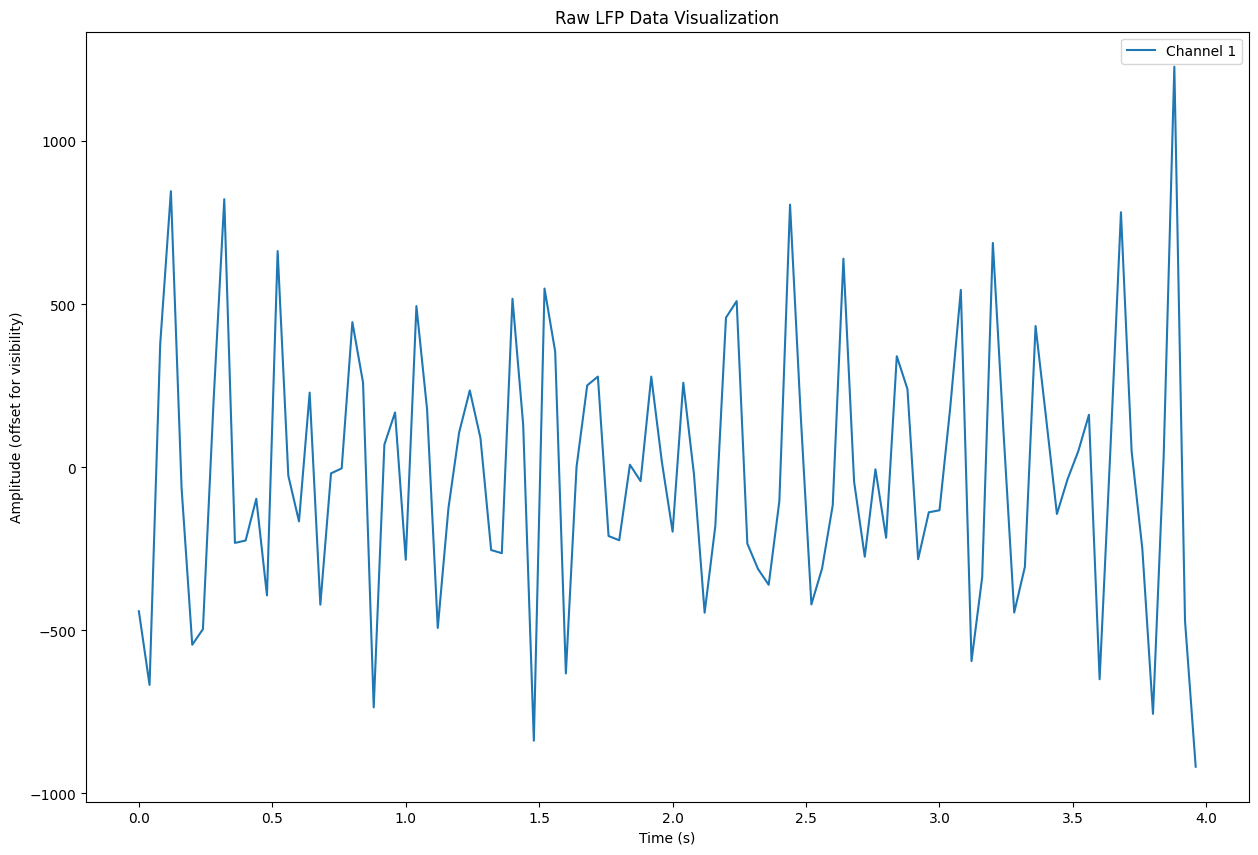

In [129]:
import matplotlib.pyplot as plt
import numpy as np

def plot_raw_lfp(LFPs, n_channels=5, start_time=0, end_time=1000, fs=25):
    """
    Plots the raw LFP data for the first n_channels within the specified time window.

    Parameters:
    LFPs (ndarray): The LFP data array of shape (samples, channels).
    n_channels (int): Number of channels to plot.
    start_time (int): Start time index.
    end_time (int): End time index.
    fs (int): Sampling frequency (Hz).
    """
    time = np.arange(start_time, end_time) / fs  # Time axis in seconds
    plt.figure(figsize=(15, 10))

    for i in range(n_channels):
        plt.plot(time, LFPs[start_time:end_time, i] + i * 200, label=f'Channel {i+1}')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (offset for visibility)')
    plt.title('Raw LFP Data Visualization')
    plt.legend(loc='upper right')
    plt.show()

# Example usage
plot_raw_lfp(LFPs, n_channels=1, start_time=0, end_time=100)


## Testing synchrony

In [117]:
print("LFPs shape:", LFPs.shape)
print("binned_pos shape:", binned_pos.shape)
print("LFPs data type:", LFPs.dtype)
print("binned_pos data type:", binned_pos.dtype)
print("LFPs contains NaN:", np.isnan(LFPs).any())
print("binned_pos contains NaN:", np.isnan(binned_pos).any())
print("LFPs contains inf:", np.isinf(LFPs).any())
print("binned_pos contains inf:", np.isinf(binned_pos).any())

LFPs shape: (170690, 384)
binned_pos shape: (170690, 3)
LFPs data type: complex128
binned_pos data type: float64
LFPs contains NaN: False
binned_pos contains NaN: True
LFPs contains inf: False
binned_pos contains inf: False


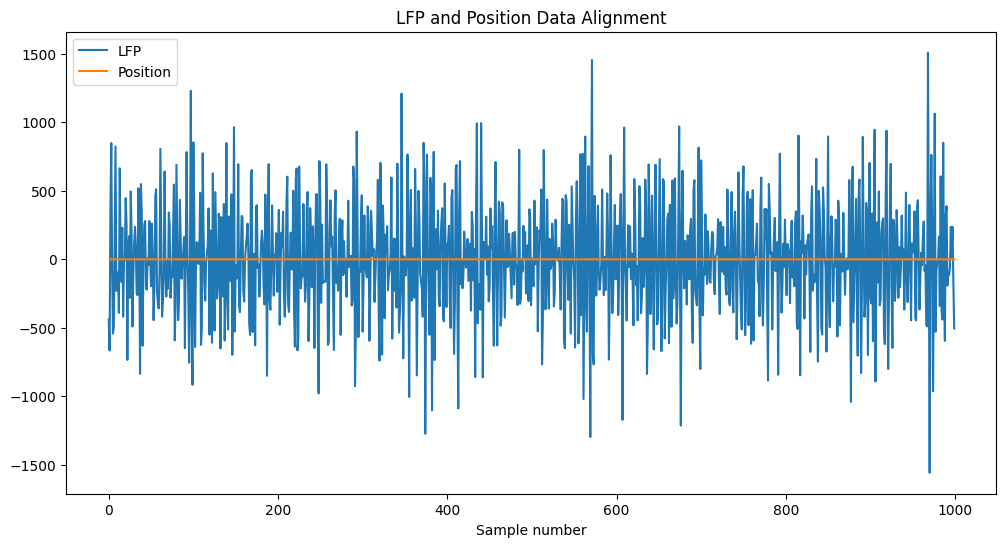

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(LFPs[:1000, 0], label='LFP')
plt.plot(binned_pos[:1000, 0], label='Position')
plt.legend()
plt.title('LFP and Position Data Alignment')
plt.xlabel('Sample number')
plt.show()

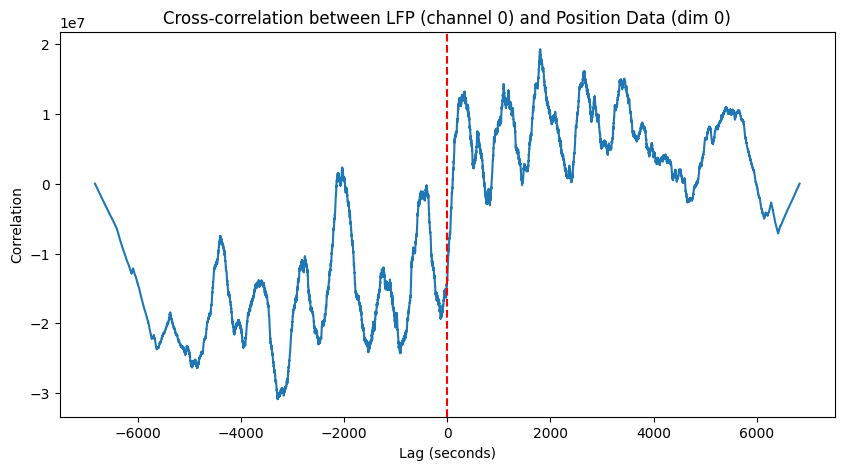

Maximum correlation occurs at lag: 1801.600 seconds


In [127]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def test_synchronization(LFPs, binned_pos, sampling_rate):
    # Choose one LFP channel and one position dimension
    lfp_channel = 0  # Change this to test different channels
    pos_dim = 0  # 0 for X, 1 for Y, 2 for Z

    lfp_data = np.abs(LFPs[:, lfp_channel])
    pos_data = binned_pos[:, pos_dim]

    # Remove NaN values
    valid_indices = ~np.isnan(pos_data)
    lfp_data = lfp_data[valid_indices]
    pos_data = pos_data[valid_indices]

    # Ensure the data have the same length
    min_length = min(len(lfp_data), len(pos_data))
    lfp_data = lfp_data[:min_length]
    pos_data = pos_data[:min_length]
    
    # Compute cross-correlation
    correlation = signal.correlate(lfp_data, pos_data, mode='full')
    lags = signal.correlation_lags(len(lfp_data), len(pos_data))
    lags = lags / sampling_rate  # Convert to seconds
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(lags, correlation)
    plt.title(f'Cross-correlation between LFP (channel {lfp_channel}) and Position Data (dim {pos_dim})')
    plt.xlabel('Lag (seconds)')
    plt.ylabel('Correlation')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()
    
    # Find the lag with maximum correlation
    max_corr_lag = lags[np.argmax(correlation)]
    print(f"Maximum correlation occurs at lag: {max_corr_lag:.3f} seconds")

# Example usage
test_synchronization(LFPs, binned_pos, 25)

# Applying TIMBRE


Initial train_inds (before balancing): 310
actual_indices length: 310
unique_elements: [0. 1. 2.]
elements_indices: {0.0: [13769, 13770, 13771, 13772, 13773, 16434, 16435, 16436, 16437, 16438, 84016, 84017, 84018, 84019, 84020, 98811, 98812, 98813, 98814, 98815, 103506, 103507, 103508, 103509, 103510, 111900, 111901, 111902, 111903, 111904, 143198, 143199, 143200, 143201, 143202, 153002, 153003, 153004, 153005, 153006], 1.0: [22184, 22185, 22186, 22187, 22188, 59610, 59611, 59612, 59613, 59614, 60564, 60565, 60566, 60567, 60568, 61212, 61213, 61214, 61215, 61216, 69809, 69810, 69811, 69812, 69813, 70575, 70576, 70577, 70578, 70579, 71814, 71815, 71816, 71817, 71818, 74194, 74195, 74196, 74197, 74198, 75383, 75384, 75385, 75386, 75387, 77126, 77127, 77128, 77129, 77130, 78105, 78106, 78107, 78108, 78109, 80247, 80248, 80249, 80250, 80251, 80749, 80750, 80751, 80752, 80753, 82762, 82763, 82764, 82765, 82766, 97260, 97261, 97262, 97263, 97264, 97992, 97993, 97994, 97995, 97996, 101856, 10

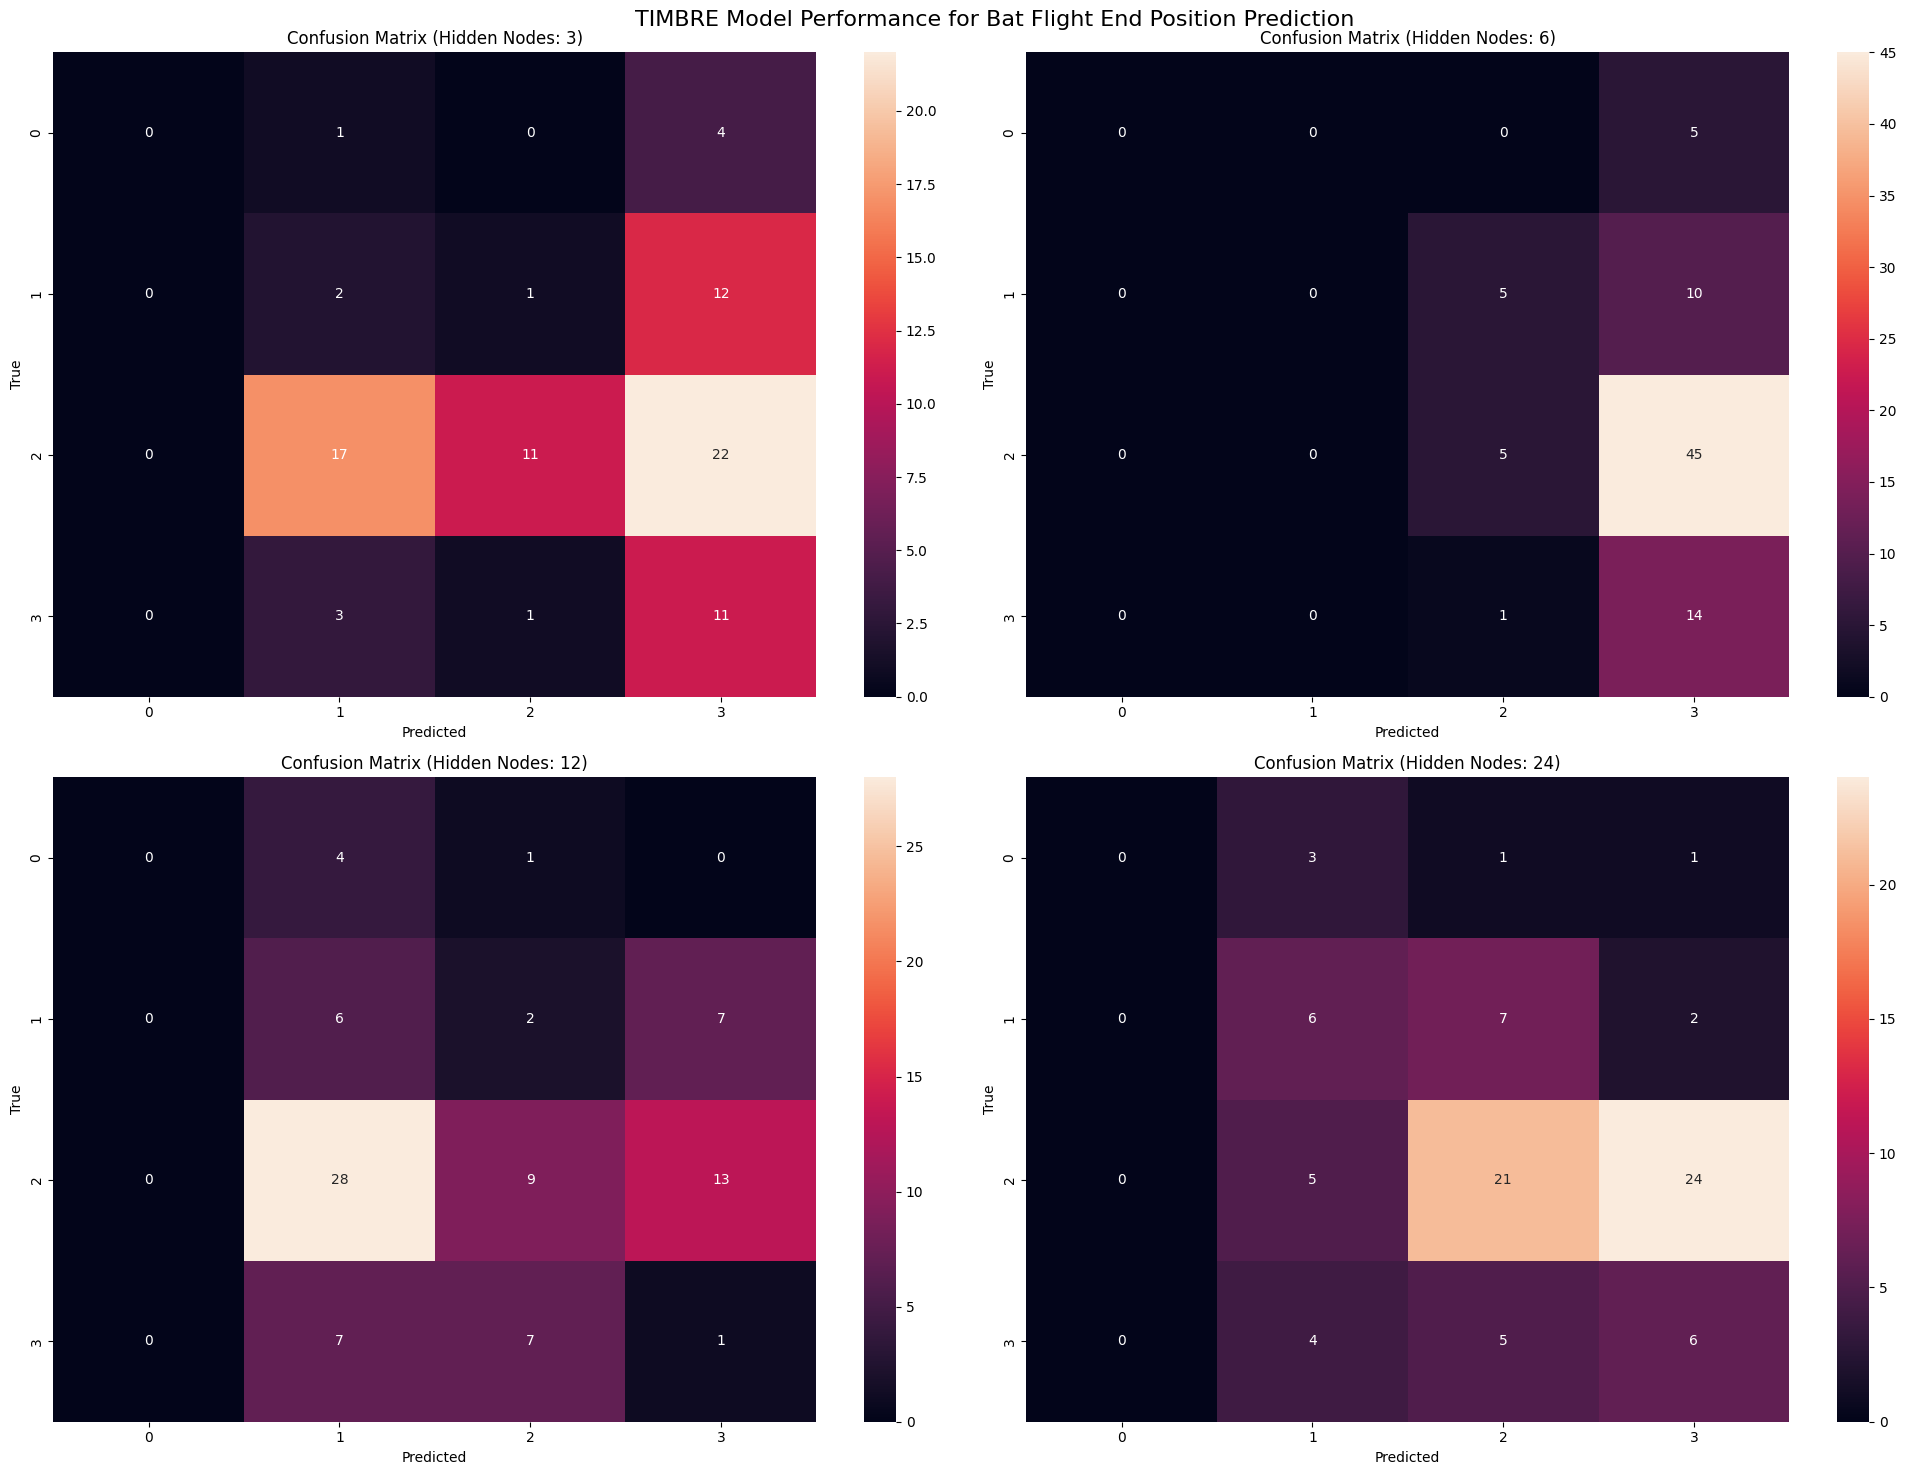

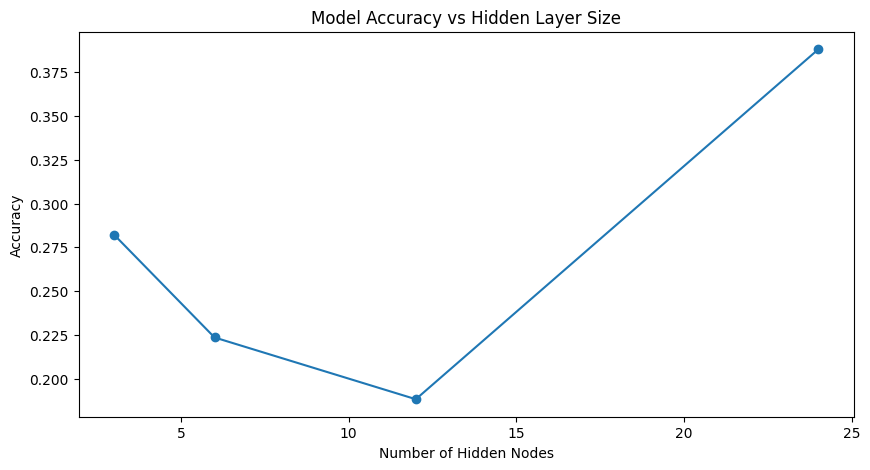

In [124]:
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('TIMBRE Model Performance for Bat Flight End Position Prediction', fontsize=16)

n_folds = 5
which_fold = 0

test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold)
wLFPs, _, _ = helpers.whiten(LFPs, train_inds)

accuracies = []
hidden_sizes = [3, 6, 12, 24]

for i, hidden_size in enumerate(hidden_sizes):
    print(f"Training network with {hidden_size} hidden nodes")
    m, _, _ = TIMBRE(wLFPs, flightID[:, 1], test_inds, train_inds, hidden_nodes=hidden_size, is_categorical=True)
    
    # Get predictions
    output_layer = helpers.layer_output(wLFPs[test_inds], m, -1)
    predictions = np.argmax(output_layer, axis=1)
    true_labels = flightID[test_inds, 1]
    
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    accuracies.append(accuracy)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Confusion Matrix (Hidden Nodes: {hidden_size})')
    axs[i//2, i%2].set_xlabel('Predicted')
    axs[i//2, i%2].set_ylabel('True')

plt.tight_layout()
plt.show()

# Plot accuracy vs model complexity
plt.figure(figsize=(10, 5))
plt.plot(hidden_sizes, accuracies, marker='o')
plt.title('Model Accuracy vs Hidden Layer Size')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Accuracy')
plt.show()